# Analysis of Accelerator-VC Bipartite Networks

Analysis of the USA accelerator-VC network using ecological metrics inspired by Theo's work on complex networks in entrepreneurial ecosystems.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import sys

sys.path.append('../../') 

# Import custom modules
from utils.data_cleaning import *
from utils.data_extraction import *
from utils.network_analysis import *

plt.style.use('default')
sns.set_palette('husl')

## Data Loading and Preparation

In [ ]:
country = "us"
data_dir = f'../../data/{country}'
raw_data = load_data(data_dir)
# Load data
companies = raw_data['companies']
investors = raw_data['investors']
investments = raw_data['investments']
funding_rounds = raw_data['funding_rounds']

print(f"Companies: {len(companies):,}")
print(f"Investors: {len(investors):,}")
print(f"Investments: {len(investments):,}")
print(f"Funding rounds: {len(funding_rounds):,}")

Companies: 820,313
Investors: 38,843
Investments: 424,188
Funding rounds: 268,283


In [ ]:
country = "us"
data_dir = f'../../data/{country}'
cleaned_data = load_clean_data(data_dir)

companies_clean = cleaned_data['companies']
investors_clean = cleaned_data['investors']
investments_clean = cleaned_data['investments']
funding_rounds_clean = cleaned_data['funding_rounds']

print(f"After cleaning:")
print(f"Companies: {len(companies_clean):,}")
print(f"Investors: {len(investors_clean):,}")
print(f"Investments: {len(investments_clean):,}")
print(f"Funding rounds: {len(funding_rounds_clean):,}")


1. Cleaning companies data
Initial companies count: 820313
Removed 140948 companies founded after 2017
Removed 82217 companies with exit status
Final companies count after cleaning: 597148
Total removed: 223165

2. Cleaning funding data
Initial investments count: 424188
Removed 34038 investments with invalid funding amounts
Final investments count after cleaning: 390150
Total removed: 34038

3. Apply funding threshold ($150,000 as per paper)
Applying funding threshold of $150,000
Companies meeting funding threshold: 59515
Filtered companies: 23320
Filtered investments: 381360

4. Excluding accelerator-only companies (prevent endogeneity bias)
Companies with accelerator-only funding: 2445
Companies after excluding accelerator-only: 22527
Investments after excluding accelerator-only: 378373

FINAL SAMPLE:
Companies: 22527
Investments: 147832
Unique investors: 22101
After cleaning:
Companies: 22,527
Investors: 38,843


In [19]:
# Save each DataFrame to its respective CSV file
data_dir = f'../../data/{country}'
companies_clean.to_csv(f'{data_dir}/companies_clean.csv', index=False)
investors_clean.to_csv(f'{data_dir}/investors_clean.csv', index=False)
investments_clean.to_csv(f'{data_dir}/investments_clean.csv', index=False)
funding_rounds_clean.to_csv(f'{data_dir}/funding_rounds_clean.csv', index=False)

print(f"Cleaned data exported to {data_dir}")

Cleaned data exported to ../../data/us


## Accelerator-VC Network Construction

In [4]:
accelerated_investments = extract_accelerator_investments(cleaned_data['investments'])

print("\nSample of accelerator investments:")
if 'company_name' in accelerated_investments.columns:
    display_cols = ['company_name', 'investor_name', 'investor_types', 'total_funding_usd']
    print(accelerated_investments[display_cols].head())
else:
    print(accelerated_investments[['org_uuid', 'investor_name', 'investor_types']].head())
    
vc_investments = extract_vc_investments(cleaned_data['investments'])

print("\nSample of VC investments:")
if 'company_name' in vc_investments.columns:
    display_cols = ['company_name', 'investor_name', 'investor_types', 'total_funding_usd']
    print(vc_investments[display_cols].head())
else:
    print(vc_investments[['org_uuid', 'investor_name', 'investor_types']].head())
    
print("\nAccelerator-VC pairs:")
accelerator_vc_investments_pairs = create_investment_pairs(accelerated_investments, vc_investments, 'acc', 'vc')
print(accelerator_vc_investments_pairs[['org_uuid', 'investor_name_acc', 'investor_name_vc']].head())

Found 7130 accelerator investments
Unique companies in accelerators: 4383

Sample of accelerator investments:
         company_name       investor_name investor_types  total_funding_usd
846        RescueTime        Y Combinator    accelerator           920000.0
1389           Scribd        Y Combinator    accelerator        106750000.0
1671       Snap Shots             Idealab      incubator         10000000.0
3211  Ambient Devices  Rose Tech Ventures      incubator          8600000.0
3218   Critical Media  Rose Tech Ventures      incubator          6200000.0
Found 103585 VC investments
Unique companies with VC funding: 16899

Sample of VC investments:
   company_name               investor_name            investor_types  \
7        Scribd                    Redpoint           venture capital   
14      MeetMoi       Acadia Woods Partners           venture capital   
19        OpenX         First Round Capital           venture capital   
20        OpenX  Oreilly AlphaTech Ventures  mi

## Static Ecological Network Analysis

Analysis using ecological metrics inspired by Carniel's framework.

In [5]:
acc_vc_edges = extract_bipartite_edges_from_pairs(
    accelerator_vc_investments_pairs, 
    'investor_name_acc', 
    'investor_name_vc',
    'total_funding_usd'
)

# Bbipartite analysis with ecological metrics
network_analysis = analyze_bipartite_structure_robust(
    acc_vc_edges,
    'investor_name_acc',
    'investor_name_vc',
    'total_funding_usd',
    'Accelerators',
    'VCs',
    handle_overlap='suffix'
)

# Extract key metrics
basic_metrics = network_analysis['basic_metrics']
ecological_summary = network_analysis['ecological_summary']

print("=== Network Structure ===")
print(f"Nodes: {basic_metrics['num_nodes']} ({basic_metrics['set_0_size']} accelerators + {basic_metrics['set_1_size']} VCs)")
print(f"Edges: {basic_metrics['num_edges']}")
print(f"Density: {basic_metrics['density']:.3f}")
print(f"Components: {basic_metrics['num_components']}")

print("\n=== Ecological Metrics ===")
print(f"Connectance: {ecological_summary['connectance']:.3f}") # Or density
print(f"Nestedness (NODF): {ecological_summary['nestedness_nodf']:.1f}")
print(f"Modularity: {ecological_summary['modularity']:.3f}")

# @todo review cross assortativity, maybe doenst make sense
# print(f"Cross-assortativity: {ecological_summary['cross_assortativity']:.3f}")

Overlapping nodes: ['Phase One Ventures', 'Owl Ventures', 'Jumpstart Ventures', 'Evolution Ventures', 'Adjacent']...
Added suffixes to create pseudo-bipartite structure
=== Network Structure ===
Nodes: 6936 (889 accelerators + 6047 VCs)
Edges: 23295
Density: 0.004
Components: 35

=== Ecological Metrics ===
Connectance: 0.004
Nestedness (NODF): 6.6
Modularity: 0.246


In [6]:
# Ecological interpretation
ecology_summary = summarize_bipartite_ecology(network_analysis)

print("=== Ecological Interpretation ===")
print(f"Network Type: {ecology_summary['network_type']}")
print(f"Connectance: {ecology_summary['connectance_interpretation']}")
print(f"Nestedness: {ecology_summary['nestedness_interpretation']}")
print(f"Modularity: {ecology_summary['modularity_interpretation']}")
print(f"Resilience: {ecology_summary['resilience_prediction']}")

=== Ecological Interpretation ===
Network Type: Mixed architecture
Connectance: Low connectance - sparse network
Nestedness: Low nestedness - modular structure
Modularity: Medium modularity - moderate communities
Resilience: Variable resilience patterns


#### Comments

Putting aside all the work that should be done to formaliza and "prove" statistically wheter such values are high, or low, I'll try to interpretate them through the lens of Network Theory, in special Social Network Theory. As we are talking about a bipartite network, ecology and mutualistic (polnazator-plants) theory will also be considered.
 
Starting by nesteness. For the french network, we've got a low (is it statistically true?) value. It means multiple things, I try to summarize some of them in the following list (not exhaustive, I am still searching for bilbiography):

- There isn't a so called "herarchical" or "mutualistic" structure, where less connected "polinizators" tend to interact with a subset of the "plants" polinized by more connected "polinizators". Slightly different interpretations (but  with similar practical consequences) ca
n be taken by considering either accelarators = polinizator and vc = plant or, the opposite, vc = polinizator and accelarator = plant.

- In any case, nestedness is also related to the vunerability of the ecosystem we're studing. It's hard to affirm categorically that a network is more vunerable or less vunerable by looking to nestedness, but we can characterize this vunerability. In one hand, higher nestedness is associated with economic resilience to external crisis in economic complexity theory (Theo has good references on that regard), but it also means that the "distribution" of how much each actor (either accelarator or vc) contributes to the overall resilience (or vunerability) is concentrated in a restricted (and probably small) group of agents. So if a strongly connected agent, which would be probably more resilient and predictable (need to prove it...), faces bankrupcy, for sure a more hierarchised (higher nestedness) will sufer more.

- From a more ecological perspective, higher nestedness tends to be associated with fewer competitaion between species, which lead to more biodiveristy, increasing "structural stability". However, disturbs on generalists tends to result on accelerated species exhaustion / depletion, as specialists become isolated (consequence of nestedness structure). So if the French acc-vc ecosystem has possibily low nestedness, the opposite line of reasoning must be applied.

Now if we look to connectance (measure the density of links, aka, ratio of number of existing links and all possible links) and modularity (indicates how sparse a matrix is, normally associated with the formation of clusters or community structures), most probably we'll be able to indentify clusters, as high modularity is associated with sparse matrix and low connectance may facilitate the visualization and interpretation of such clusters (to be obtained with non-supervised learning....)

## Time Series Ecological Network Analysis

In [7]:
# Extract year from funding rounds for time series analysis
# Merge investment data with funding rounds to get temporal information
acc_vc_inv_pairs_ts = accelerator_vc_investments_pairs.copy()

# Convert to datetime and extract year
# acc_vc_inv_pairs_ts['announced_year'] = pd.to_datetime(acc_vc_inv_pairs_ts['announced_year'])
acc_vc_inv_pairs_ts['year'] = acc_vc_inv_pairs_ts['announced_year']

# Get the range of years
min_year = 2011
max_year = 2023

# Filter out rows with missing dates
acc_vc_inv_pairs_ts = acc_vc_inv_pairs_ts.dropna(subset=['year'])
acc_vc_inv_pairs_ts = acc_vc_inv_pairs_ts[(acc_vc_inv_pairs_ts['year'] >= min_year) & (acc_vc_inv_pairs_ts['year'] <= max_year)]


print(f"Time series analysis from {min_year} to {max_year}")
print(f"Total investments with dates: {len(acc_vc_inv_pairs_ts):,}")

# Show distribution by year
year_counts = acc_vc_inv_pairs_ts['year'].value_counts().sort_index()
print(f"\nInvestments per year:")
print(year_counts)

Time series analysis from 2011 to 2023
Total investments with dates: 59,062

Investments per year:
year
2011     429
2012     935
2013    1468
2014    2600
2015    3547
2016    4998
2017    6405
2018    7182
2019    6671
2020    6658
2021    9930
2022    5585
2023    2654
Name: count, dtype: int64


### Snapshot-based analysis

In [8]:
# Initialize storage for time series metrics
time_series_metrics = []

# Minimum number of edges required for meaningful analysis
min_edges_threshold = 10

print("Computing ecological metrics for each year...")
print("=" * 50)

# Loop through each year and calculate metrics
for year in range(min_year, max_year + 1):
    cur_year_acc_vc_inv_pairs = acc_vc_inv_pairs_ts[acc_vc_inv_pairs_ts['year'] == year]

    if len(cur_year_acc_vc_inv_pairs) < min_edges_threshold:
        print(f"Year {year}: Skipping (only {len(cur_year_acc_vc_inv_pairs)} investments)")
        continue
    
    try:
        # Extract bipartite edges for this year
        year_edges = extract_bipartite_edges_from_pairs(
            cur_year_acc_vc_inv_pairs,
            'investor_name_acc',
            'investor_name_vc',
            'total_funding_usd'
        )

        # Analyze bipartite structure for this year
        year_analysis = analyze_bipartite_structure_robust(
            year_edges,
            'investor_name_acc',
            'investor_name_vc',
            'total_funding_usd',
            'Accelerators',
            'VCs',
            handle_overlap='suffix'
        )
        
        # Extract metrics
        basic_metrics = year_analysis['basic_metrics']
        ecological_summary = year_analysis['ecological_summary']
        
        # Store metrics for this year
        year_metrics = {
            'year': year,
            'num_nodes': basic_metrics['num_nodes'],
            'num_accelerators': basic_metrics['set_0_size'],
            'num_vcs': basic_metrics['set_1_size'],
            'num_edges': basic_metrics['num_edges'],
            'density': basic_metrics['density'],
            'connectance': ecological_summary['connectance'],
            'nestedness_nodf': ecological_summary['nestedness_nodf'],
            'modularity': ecological_summary['modularity'],
            'cross_assortativity': ecological_summary['cross_assortativity'],
            'num_components': basic_metrics['num_components']
        }
        
        time_series_metrics.append(year_metrics)
        
        print(f"Year {year}: {basic_metrics['num_nodes']} nodes, {basic_metrics['num_edges']} edges, "
              f"Connectance: {ecological_summary['connectance']:.3f}, "
              f"Nestedness: {ecological_summary['nestedness_nodf']:.1f}, "
              f"Modularity: {ecological_summary['modularity']:.3f}")
        
    except Exception as e:
        print(f"Year {year}: Error - {str(e)}")
        continue

print(f"\nSuccessfully analyzed {len(time_series_metrics)} years")

Computing ecological metrics for each year...
Year 2011: 249 nodes, 284 edges, Connectance: 0.024, Nestedness: 7.9, Modularity: 0.401
Year 2012: 408 nodes, 512 edges, Connectance: 0.016, Nestedness: 7.5, Modularity: 0.399
Year 2013: 647 nodes, 937 edges, Connectance: 0.011, Nestedness: 6.4, Modularity: 0.364
Year 2014: 913 nodes, 1500 edges, Connectance: 0.009, Nestedness: 6.6, Modularity: 0.346
Year 2015: 1217 nodes, 2153 edges, Connectance: 0.008, Nestedness: 6.8, Modularity: 0.322
Overlapping nodes: ['Phase One Ventures']
Added suffixes to create pseudo-bipartite structure
Year 2016: 1487 nodes, 2698 edges, Connectance: 0.007, Nestedness: 6.9, Modularity: 0.332
Year 2017: 1890 nodes, 3638 edges, Connectance: 0.006, Nestedness: 6.6, Modularity: 0.321
Overlapping nodes: ['Owl Ventures']
Added suffixes to create pseudo-bipartite structure
Year 2018: 2180 nodes, 4223 edges, Connectance: 0.005, Nestedness: 5.9, Modularity: 0.327
Year 2019: 2127 nodes, 3837 edges, Connectance: 0.005, Nest

In [9]:
# Convert to DataFrame for easier analysis and plotting
ts_df = pd.DataFrame(time_series_metrics)

if len(ts_df) > 0:
    print("Time Series Metrics Summary:")
    print(ts_df.describe().round(3))
    
    print(f"\nData available for years: {ts_df['year'].min()} to {ts_df['year'].max()}")
    print(f"Number of years analyzed: {len(ts_df)}")
else:
    print("No time series data available for analysis")

Time Series Metrics Summary:
           year  num_nodes  num_accelerators   num_vcs  num_edges  density  \
count    13.000     13.000            13.000    13.000     13.000   13.000   
mean   2017.000   1508.231           320.077  1188.154   2691.692    0.009   
std       3.894    798.108           139.693   663.887   1645.883    0.006   
min    2011.000    249.000            64.000   185.000    284.000    0.005   
25%    2014.000    913.000           239.000   674.000   1500.000    0.005   
50%    2017.000   1487.000           350.000  1137.000   2698.000    0.006   
75%    2020.000   2164.000           434.000  1711.000   3837.000    0.009   
max    2023.000   2843.000           482.000  2361.000   5755.000    0.024   

       connectance  nestedness_nodf  modularity  cross_assortativity  \
count       13.000           13.000      13.000               13.000   
mean         0.009            6.206       0.351               -0.097   
std          0.006            1.067       0.032     

Evolution of ecological metrics over time in the accelerator-VC ecosystem.

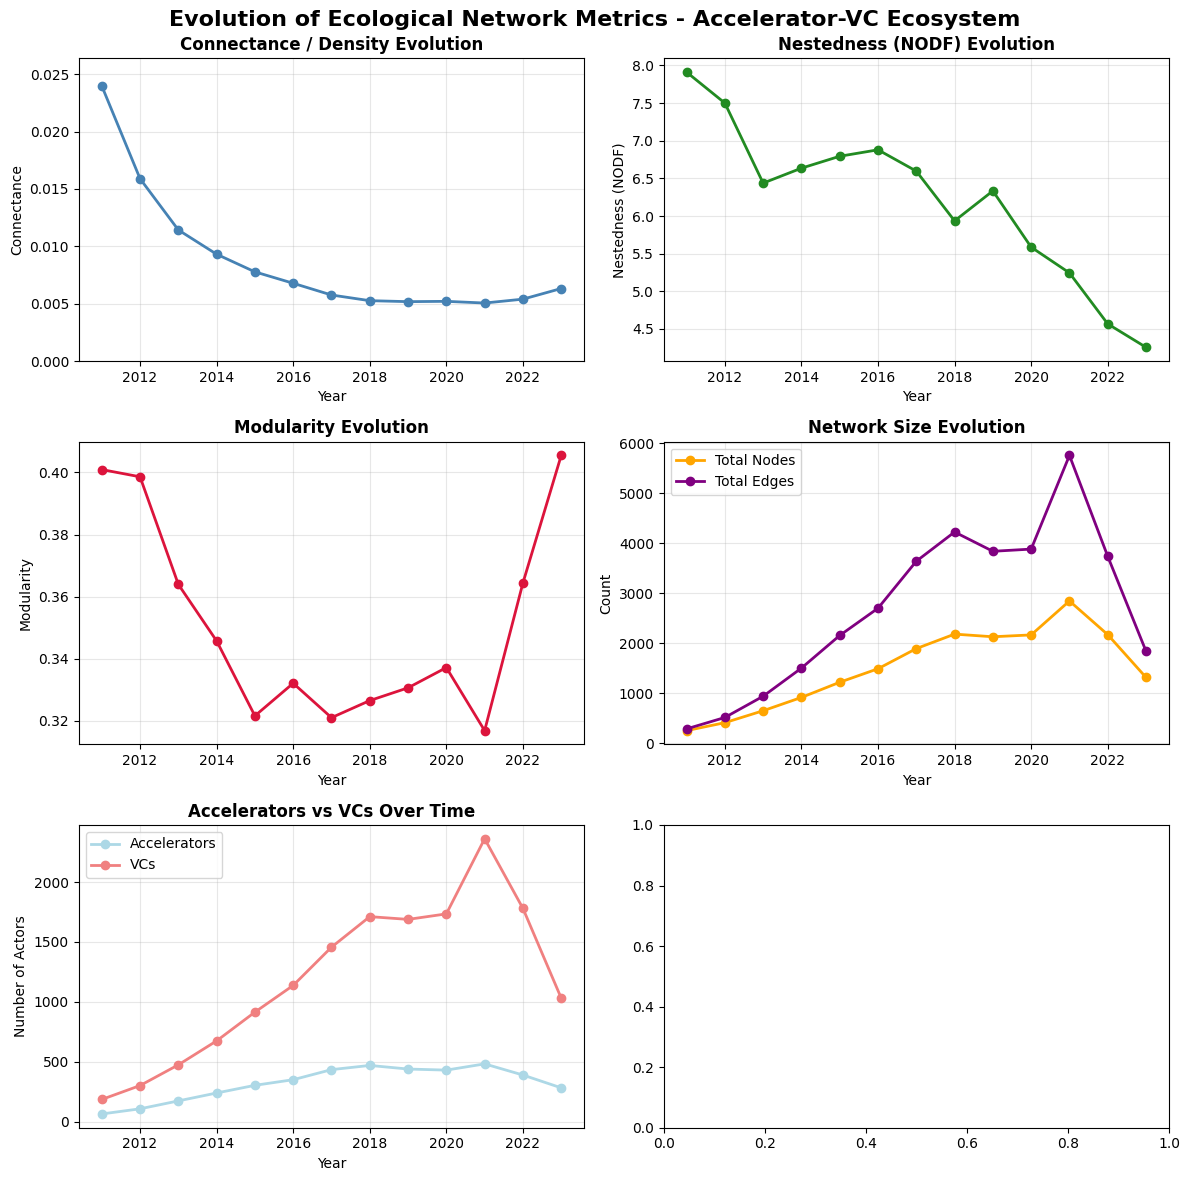

In [10]:
if len(ts_df) > 0:
    # Create comprehensive time series plot
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    fig.suptitle('Evolution of Ecological Network Metrics - Accelerator-VC Ecosystem', 
                 fontsize=16, fontweight='bold')
    
    # Connectance evolution
    axes[0, 0].plot(ts_df['year'], ts_df['connectance'], 'o-', linewidth=2, markersize=6, color='steelblue')
    axes[0, 0].set_title('Connectance / Density Evolution', fontweight='bold')
    axes[0, 0].set_xlabel('Year')
    axes[0, 0].set_ylabel('Connectance')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim(0, max(ts_df['connectance']) * 1.1)
    
    # Nestedness evolution
    axes[0, 1].plot(ts_df['year'], ts_df['nestedness_nodf'], 'o-', linewidth=2, markersize=6, color='forestgreen')
    axes[0, 1].set_title('Nestedness (NODF) Evolution', fontweight='bold')
    axes[0, 1].set_xlabel('Year')
    axes[0, 1].set_ylabel('Nestedness (NODF)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Modularity evolution
    axes[1, 0].plot(ts_df['year'], ts_df['modularity'], 'o-', linewidth=2, markersize=6, color='crimson')
    axes[1, 0].set_title('Modularity Evolution', fontweight='bold')
    axes[1, 0].set_xlabel('Year')
    axes[1, 0].set_ylabel('Modularity')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Network size evolution
    axes[1, 1].plot(ts_df['year'], ts_df['num_nodes'], 'o-', linewidth=2, markersize=6, color='orange', label='Total Nodes')
    axes[1, 1].plot(ts_df['year'], ts_df['num_edges'], 'o-', linewidth=2, markersize=6, color='purple', label='Total Edges')
    axes[1, 1].set_title('Network Size Evolution', fontweight='bold')
    axes[1, 1].set_xlabel('Year')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    axes[2, 0].plot(ts_df['year'], ts_df['num_accelerators'], 'o-', linewidth=2, markersize=6, 
                color='lightblue', label='Accelerators')
    axes[2, 0].plot(ts_df['year'], ts_df['num_vcs'], 'o-', linewidth=2, markersize=6, 
                color='lightcoral', label='VCs')
    axes[2, 0].set_title('Accelerators vs VCs Over Time', fontweight='bold')
    axes[2, 0].set_xlabel('Year')
    axes[2, 0].set_ylabel('Number of Actors')
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for time series visualization")

=== Temporal Trends Analysis ===

Year-over-Year Changes (average):
connectance: -0.0015 per year (total: -0.0177)
nestedness_nodf: -0.3046 per year (total: -3.6547)
modularity: +0.0004 per year (total: +0.0046)
num_nodes: +88.6667 per year (total: +1064.0000)
num_edges: +129.5000 per year (total: +1554.0000)

Correlations between metrics and time:
connectance: r=-0.779 (decreasing trend)
nestedness_nodf: r=-0.930 (decreasing trend)
modularity: r=-0.228 (decreasing trend)


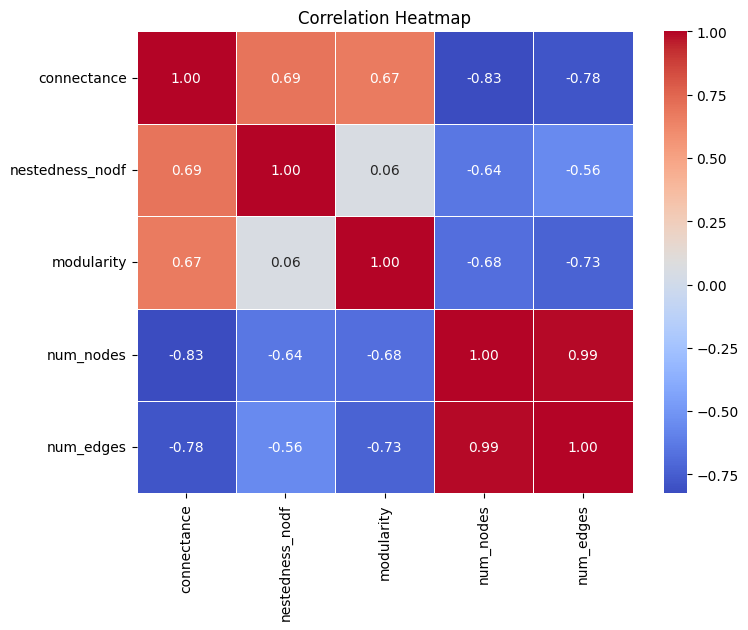

In [11]:
if len(ts_df) > 1:
    # Calculate trends and correlations
    print("=== Temporal Trends Analysis ===")
    
    # Calculate year-over-year changes
    ts_df_sorted = ts_df.sort_values('year')
    
    metrics_to_analyze = ['connectance', 'nestedness_nodf', 'modularity', 'num_nodes', 'num_edges']
    
    print("\nYear-over-Year Changes (average):")
    for metric in metrics_to_analyze:
        if metric in ts_df_sorted.columns:
            # Calculate differences
            diffs = ts_df_sorted[metric].diff().dropna()
            avg_change = diffs.mean()
            total_change = ts_df_sorted[metric].iloc[-1] - ts_df_sorted[metric].iloc[0]
            print(f"{metric}: {avg_change:+.4f} per year (total: {total_change:+.4f})")
    
    # Correlation analysis
    print("\nCorrelations between metrics and time:")
    for metric in ['connectance', 'nestedness_nodf', 'modularity']:
        if metric in ts_df.columns:
            correlation = ts_df['year'].corr(ts_df[metric])
            trend_direction = "increasing" if correlation > 0.1 else "decreasing" if correlation < -0.1 else "stable"
            print(f"{metric}: r={correlation:.3f} ({trend_direction} trend)")
            
    matrix = ts_df_sorted[metrics_to_analyze].corr()

    plt.figure(figsize=(8,6))
    sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Heatmap")
    plt.show()

else:
    print("Insufficient data for temporal trends analysis (need at least 2 years)")

#### Comments

The time series analysis reveals how the French accelerator-VC ecosystem has evolved over time. Key insights to consider:

- **Connectance trends**: Changes in network density may indicate ecosystem maturation or market concentration
- **Nestedness evolution**: Temporal changes in hierarchical structure reflect ecosystem organization and potential vulnerability patterns
- **Modularity dynamics**: Evolution of community structure indicates specialization and clustering patterns
- **Growth patterns**: The relationship between network size and structural metrics reveals ecosystem scaling properties. Event scaling

These temporal patterns can be compared with economic cycles, policy changes, and market events to understand ecosystem resilience and adaptation mechanisms.

...Nestedness and modularity over year seems to follow inverse proportion

Before 2017 -> lower modularity and higher nestedness trends
After 20217 -> higher modularity and lower nestedess trends

- Why has it changed so much ?

Following literature interpretation:

**High modularity and low nestedness** → strongly compartmentalized networks, but without internal hierarchy.
Example: ecosystems with isolated guilds, almost no species overlap.

**Low modularity and high nestedness** → non-compartmentalized networks, but with a clear hierarchy of connections.
Example: mutualistic plant-pollinator networks in tropical ecosystems.

**High modularity and high nestedness** → rare, but possible if each module is internally nested (hierarchical structures within compartments).

**Low modularity and low nestedness** → more random networks, with no evident pattern.

### Cumulative network analysis (5 years window)

In [12]:
# Initialize storage for time series metrics
ts_cumulative_metrics = []
cumulative_window = 5

# Minimum number of edges required for meaningful analysis
min_edges_threshold = 10

print(f"Computing ecological metrics for each year ({cumulative_window} years window)...")
print("=" * 50)

# Loop through each year and calculate metrics
for year in range(min_year, max_year + 1):
    cur_window_acc_vc_inv_pairs = acc_vc_inv_pairs_ts[(acc_vc_inv_pairs_ts['year'] >= year) & (acc_vc_inv_pairs_ts['year'] >= year - cumulative_window)]
    
    try:
        # Extract bipartite edges for this year
        window_edges = extract_bipartite_edges_from_pairs(
            cur_window_acc_vc_inv_pairs,
            'investor_name_acc',
            'investor_name_vc',
            'total_funding_usd'
        )
        
        # Analyze bipartite structure for this year
        window_analysis = analyze_bipartite_structure_robust(
            window_edges,
            'investor_name_acc',
            'investor_name_vc',
            'total_funding_usd',
            'Accelerators',
            'VCs',
            handle_overlap='suffix'
        )
        
        # Extract metrics
        cumulative_basic_metrics = window_analysis['basic_metrics']
        cumulative_eco_summary = window_analysis['ecological_summary']
        
        # Store metrics for this year
        cumulative_year_metrics = {
            'year': year,
            'num_nodes': cumulative_basic_metrics['num_nodes'],
            'num_accelerators': cumulative_basic_metrics['set_0_size'],
            'num_vcs': cumulative_basic_metrics['set_1_size'],
            'num_edges': cumulative_basic_metrics['num_edges'],
            'density': cumulative_basic_metrics['density'],
            'connectance': cumulative_eco_summary['connectance'],
            'nestedness_nodf': cumulative_eco_summary['nestedness_nodf'],
            'modularity': cumulative_eco_summary['modularity'],
            'cross_assortativity': cumulative_eco_summary['cross_assortativity'],
            'num_components': cumulative_basic_metrics['num_components']
        }
        
        ts_cumulative_metrics.append(cumulative_year_metrics)
        
        print(f"Year {year}: {cumulative_basic_metrics['num_nodes']} nodes, {cumulative_basic_metrics['num_edges']} edges, "
              f"Connectance: {cumulative_eco_summary['connectance']:.3f}, "
              f"Nestedness: {cumulative_eco_summary['nestedness_nodf']:.1f}, "
              f"Modularity: {cumulative_eco_summary['modularity']:.3f}")
        
    except Exception as e:
        print(f"Year {year}: Error - {str(e)}")
        continue

print(f"\nSuccessfully analyzed {len(ts_cumulative_metrics)} years")

Computing ecological metrics for each year (5 years window)...
Overlapping nodes: ['Phase One Ventures', 'Owl Ventures', 'Jumpstart Ventures', 'Evolution Ventures', 'Adjacent']...
Added suffixes to create pseudo-bipartite structure
Year 2011: 6656 nodes, 22452 edges, Connectance: 0.004, Nestedness: 6.8, Modularity: 0.256
Overlapping nodes: ['Phase One Ventures', 'Owl Ventures', 'Jumpstart Ventures', 'Evolution Ventures', 'Adjacent']...
Added suffixes to create pseudo-bipartite structure
Year 2012: 6630 nodes, 22343 edges, Connectance: 0.004, Nestedness: 6.8, Modularity: 0.252
Overlapping nodes: ['Phase One Ventures', 'Owl Ventures', 'Jumpstart Ventures', 'Evolution Ventures', 'Adjacent']
Added suffixes to create pseudo-bipartite structure
Year 2013: 6580 nodes, 22132 edges, Connectance: 0.004, Nestedness: 6.8, Modularity: 0.256
Overlapping nodes: ['Phase One Ventures', 'Owl Ventures', 'Jumpstart Ventures', 'Evolution Ventures', 'Adjacent']
Added suffixes to create pseudo-bipartite stru

In [13]:
# Convert to DataFrame for easier analysis and plotting
ts_cumulative_df = pd.DataFrame(ts_cumulative_metrics)

if len(ts_cumulative_df) > 0:
    print("Time Series Metrics Summary:")
    print(ts_cumulative_df.describe().round(3))
    
    print(f"\nData available for years: {ts_cumulative_df['year'].min()} to {ts_cumulative_df['year'].max()}")
    print(f"Number of years analyzed: {len(ts_cumulative_df)}")
else:
    print("No time series data available for analysis")

Time Series Metrics Summary:
           year  num_nodes  num_accelerators   num_vcs  num_edges  density  \
count    13.000     13.000            13.000    13.000     13.000   13.000   
mean   2017.000   5300.308           734.308  4566.000  15999.385    0.005   
std       3.894   1653.785           177.234  1476.978   6899.362    0.001   
min    2011.000   1313.000           282.000  1031.000   1838.000    0.004   
25%    2014.000   4748.000           687.000  4061.000  12104.000    0.004   
50%    2017.000   5990.000           805.000  5185.000  18578.000    0.004   
75%    2020.000   6499.000           858.000  5641.000  21701.000    0.004   
max    2023.000   6656.000           876.000  5780.000  22452.000    0.006   

       connectance  nestedness_nodf  modularity  cross_assortativity  \
count       13.000           13.000      13.000               13.000   
mean         0.005            6.025       0.283               -0.103   
std          0.001            0.885       0.045     

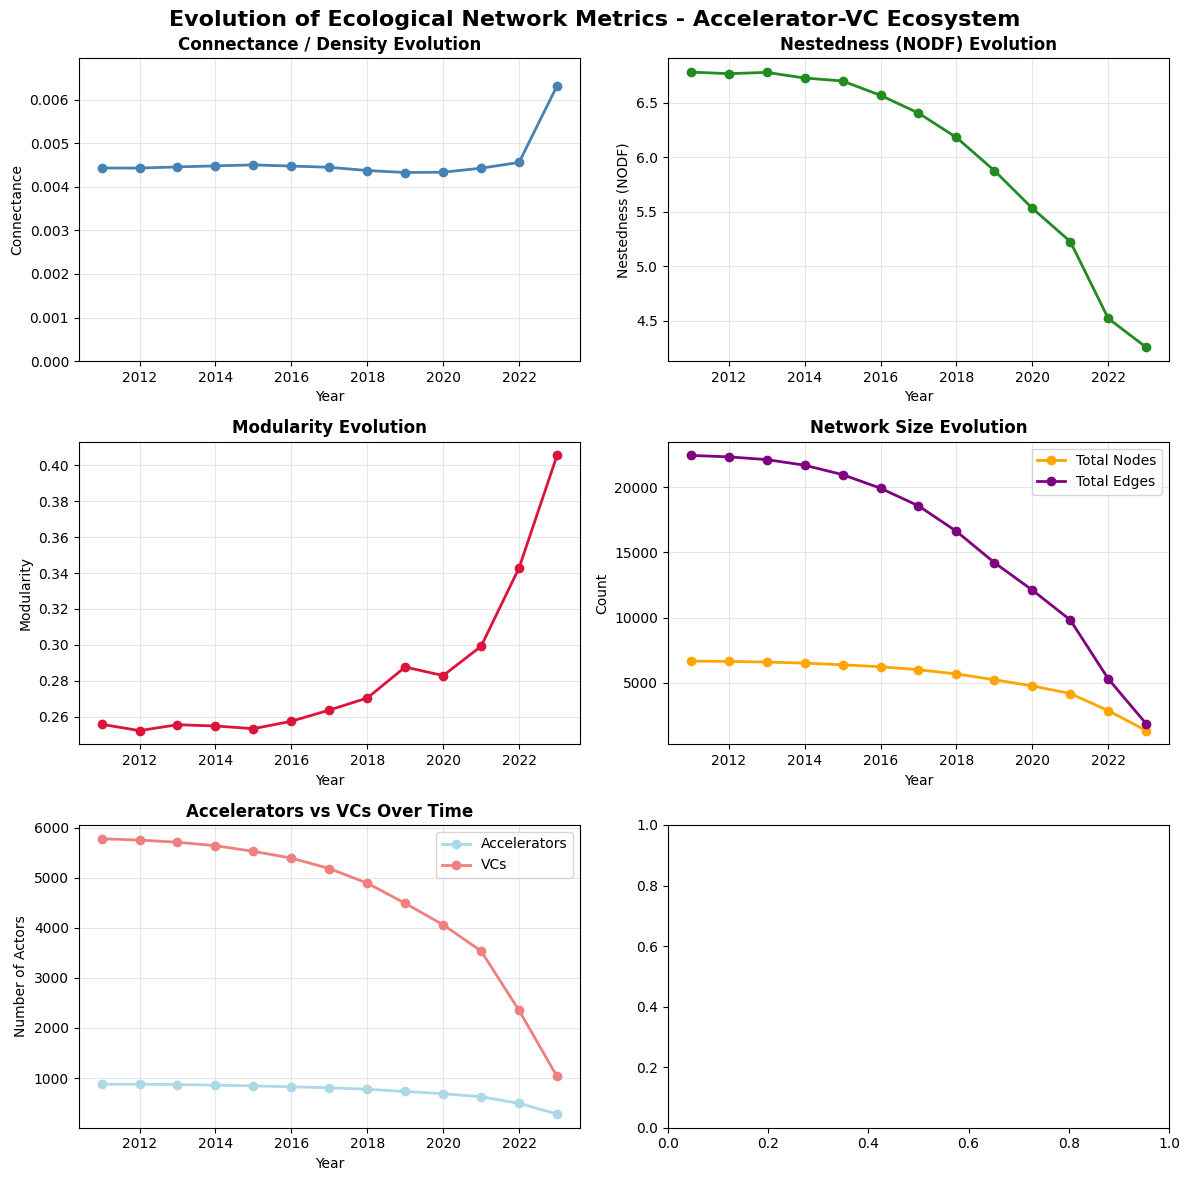

In [14]:
if len(ts_cumulative_df) > 0:
    # Create comprehensive time series plot
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    fig.suptitle('Evolution of Ecological Network Metrics - Accelerator-VC Ecosystem', 
                 fontsize=16, fontweight='bold')
    
    # Connectance evolution
    axes[0, 0].plot(ts_cumulative_df['year'], ts_cumulative_df['connectance'], 'o-', linewidth=2, markersize=6, color='steelblue')
    axes[0, 0].set_title('Connectance / Density Evolution', fontweight='bold')
    axes[0, 0].set_xlabel('Year')
    axes[0, 0].set_ylabel('Connectance')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim(0, max(ts_cumulative_df['connectance']) * 1.1)
    
    # Nestedness evolution
    axes[0, 1].plot(ts_cumulative_df['year'], ts_cumulative_df['nestedness_nodf'], 'o-', linewidth=2, markersize=6, color='forestgreen')
    axes[0, 1].set_title('Nestedness (NODF) Evolution', fontweight='bold')
    axes[0, 1].set_xlabel('Year')
    axes[0, 1].set_ylabel('Nestedness (NODF)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Modularity evolution
    axes[1, 0].plot(ts_cumulative_df['year'], ts_cumulative_df['modularity'], 'o-', linewidth=2, markersize=6, color='crimson')
    axes[1, 0].set_title('Modularity Evolution', fontweight='bold')
    axes[1, 0].set_xlabel('Year')
    axes[1, 0].set_ylabel('Modularity')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Network size evolution
    axes[1, 1].plot(ts_cumulative_df['year'], ts_cumulative_df['num_nodes'], 'o-', linewidth=2, markersize=6, color='orange', label='Total Nodes')
    axes[1, 1].plot(ts_cumulative_df['year'], ts_cumulative_df['num_edges'], 'o-', linewidth=2, markersize=6, color='purple', label='Total Edges')
    axes[1, 1].set_title('Network Size Evolution', fontweight='bold')
    axes[1, 1].set_xlabel('Year')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    axes[2, 0].plot(ts_cumulative_df['year'], ts_cumulative_df['num_accelerators'], 'o-', linewidth=2, markersize=6, 
                color='lightblue', label='Accelerators')
    axes[2, 0].plot(ts_cumulative_df['year'], ts_cumulative_df['num_vcs'], 'o-', linewidth=2, markersize=6, 
                color='lightcoral', label='VCs')
    axes[2, 0].set_title('Accelerators vs VCs Over Time', fontweight='bold')
    axes[2, 0].set_xlabel('Year')
    axes[2, 0].set_ylabel('Number of Actors')
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for time series visualization")

=== Temporal Trends Analysis ===

Year-over-Year Changes (average):
connectance: +0.0002 per year (total: +0.0019)
nestedness_nodf: -0.2104 per year (total: -2.5248)
modularity: +0.0125 per year (total: +0.1497)
num_nodes: -445.2500 per year (total: -5343.0000)
num_edges: -1717.8333 per year (total: -20614.0000)

Correlations between metrics and time:
connectance: r=0.447 (increasing trend)
nestedness_nodf: r=-0.924 (decreasing trend)
modularity: r=0.807 (increasing trend)


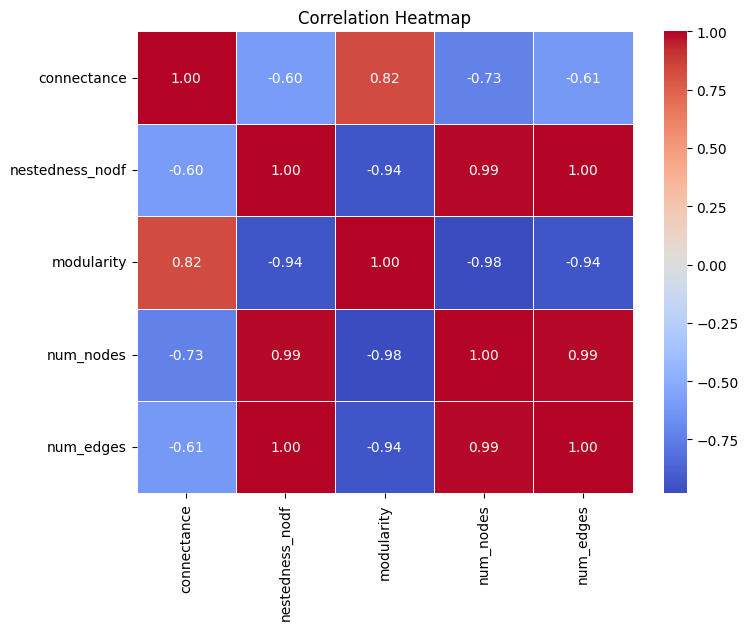

In [15]:
if len(ts_cumulative_df) > 1:
    # Calculate trends and correlations
    print("=== Temporal Trends Analysis ===")
    
    # Calculate year-over-year changes
    ts_cumulative_df_sorted = ts_cumulative_df.sort_values('year')
    
    cumulative_metrics_to_analyze = ['connectance', 'nestedness_nodf', 'modularity', 'num_nodes', 'num_edges']
    
    print("\nYear-over-Year Changes (average):")
    for metric in cumulative_metrics_to_analyze:
        if metric in ts_cumulative_df_sorted.columns:
            # Calculate differences
            diffs = ts_cumulative_df_sorted[metric].diff().dropna()
            avg_change = diffs.mean()
            total_change = ts_cumulative_df_sorted[metric].iloc[-1] - ts_cumulative_df_sorted[metric].iloc[0]
            print(f"{metric}: {avg_change:+.4f} per year (total: {total_change:+.4f})")
    
    # Correlation analysis
    print("\nCorrelations between metrics and time:")
    for metric in ['connectance', 'nestedness_nodf', 'modularity']:
        if metric in ts_cumulative_df.columns:
            correlation = ts_cumulative_df['year'].corr(ts_cumulative_df[metric])
            trend_direction = "increasing" if correlation > 0.1 else "decreasing" if correlation < -0.1 else "stable"
            print(f"{metric}: r={correlation:.3f} ({trend_direction} trend)")
            
    cum_matrix = ts_cumulative_df_sorted[cumulative_metrics_to_analyze].corr()

    plt.figure(figsize=(8,6))
    sns.heatmap(cum_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Heatmap")
    plt.show()

else:
    print("Insufficient data for temporal trends analysis (need at least 2 years)")

## Export results

In [16]:
# Save time series results for further analysis
if len(ts_df) > 0:
    # Create comprehensive time series report
    time_series_report = {
        'dataset': f'Startup Ecosystem - Time Series ({country})',
        'analysis_date': '2025-07-26',
        'time_period': {
            'start_year': int(ts_df['year'].min()),
            'end_year': int(ts_df['year'].max()),
            'num_years_analyzed': len(ts_df)
        },
        'annual_metrics': ts_df.to_dict('records'),
        'trends': {}
    }
    
    # Add trend calculations if enough data
    if len(ts_df) > 1:
        for metric in ['connectance', 'nestedness_nodf', 'modularity']:
            correlation = ts_df['year'].corr(ts_df[metric])
            time_series_report['trends'][metric] = {
                'correlation_with_time': correlation,
                'trend_direction': 'increasing' if correlation > 0.1 else 'decreasing' if correlation < -0.1 else 'stable'
            }
    
    # Save to file
    import json
    with open(f'{country}_network_timeseries_2025.json', 'w') as f:
        json.dump(time_series_report, f, indent=2, default=str)
    
    print(f"Time series analysis saved to '{country}_network_timeseries_2025.json'")
    print(f"Analysis covers {len(ts_df)} years from {ts_df['year'].min()} to {ts_df['year'].max()}")
else:
    print("No time series data to save")

Time series analysis saved to 'us_network_timeseries_2025.json'
Analysis covers 13 years from 2011 to 2023


In [17]:
# Save report for future comparisons
""" import json
with open('network_report_2025.json', 'w') as f:
    json.dump(network_report, f, indent=2, default=str)

print("Network report saved to 'network_report_2025.json'")
print("Ready for comparative analysis with other datasets.") """

' import json\nwith open(\'network_report_2025.json\', \'w\') as f:\n    json.dump(network_report, f, indent=2, default=str)\n\nprint("Network report saved to \'network_report_2025.json\'")\nprint("Ready for comparative analysis with other datasets.") '